First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [148]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt

In [2]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
import uuid
from starvers.starvers import TripleStoreEngine

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [3]:
executed_by ='stud-id_12434660'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [4]:
# group id for this project
group_id = '02'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12434660'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12440619'  # Replace the digits after "id_" with student B's student ID

In [5]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [6]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [7]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [8]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [9]:
# Ontologies used: foaf, prov, IAO
registration_triples_a = [
    f':{student_a} rdf:type foaf:Person .',
    f':{student_a} rdf:type prov:Agent .',
    f':{student_a} foaf:givenName "Miha" .',
    f':{student_a} foaf:familyName "Prah" .',
    f':{student_a} <http://vivoweb.org/ontology/core#identifier> "12434660"^^xsd:string .',
]

registration_triples_b = [
    f':{student_b} rdf:type foaf:Person .',
    f':{student_b} rdf:type prov:Agent .',
    f':{student_b} foaf:givenName "Jakov" .',
    f':{student_b} foaf:familyName "Mutvar" .',
    f':{student_b} <http://vivoweb.org/ontology/core#identifier> "12440619"^^xsd:string .',
]



role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(registration_triples_a, prefixes=prefixes)
engine.insert(registration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

## Business Understanding 

In [10]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [11]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
The dataset used in this project is the Spotify 1 Million Tracks collection obtained from Kaggle, containing roughly
one million songs with detailed metadata—such as artist name, track title, release year, genre, and an engagement-based
popularity score—alongside Spotify’s engineered audio features, including danceability, energy, loudness, acousticness, instrumentalness,
valence, tempo, and duration. These attributes describe the intrinsic characteristics of each track independently of user behaviour and
therefore allow the construction of models that attempt to estimate popularity solely from acoustic and contextual properties.
The business scenario motivating this analysis is that of a music-streaming platform seeking to evaluate newly ingested tracks before
any substantial listening history exists: because early playlist placement and promotion strongly influence long-term performance, the
platform requires a data-driven mechanism to identify promising tracks based only on their audio profile and metadata. The dataset aligns
directly with this need, providing a large, diverse basis for analysing whether a track’s inherent musical properties can serve as reliable
predictors of its eventual popularity.
"""

business_objectives_comment = """
The primary objective of the streaming platform in this scenario is to strengthen its early decision-making for newly released
or newly ingested tracks, for which no meaningful user engagement data is yet available. By predicting the likelihood that a track
will achieve above-average popularity using only its intrinsic acoustic and metadata attributes, the platform aims to improve the
efficiency of its playlist-curation and recommendation processes. More accurate early assessments enable the platform to allocate promotional
exposure more selectively, reduce dependence on manual curation, and increase listener engagement by prioritizing content with high
potential impact. Ultimately, the objective is to support more effective catalogue management in a context where the volume of incoming
tracks exceeds the platform’s capacity for human evaluation.
"""

business_success_criteria_comment = """
Business success in this context is defined by measurable improvements in how the platform identifies and promotes promising tracks
before user engagement signals accumulate. Success would be reflected in higher downstream listener engagement for tracks selected through
the predictive system compared with those promoted under existing heuristics, as well as reductions in manual curation effort due to increased
automation of early-stage selection. Additionally, successful deployment would lead to more efficient allocation of promotional resources,
observable through improved performance of curated playlists or early-exposure campaigns. These outcomes must be attributable to the predictive
system’s ability to surface high-potential tracks earlier and more consistently than current operational processes.
"""

data_mining_goals_comment = """
The central data mining goal is to construct and evaluate a predictive model that estimates a track’s future popularity class
based solely on the attributes available at the time of ingestion, namely its audio features and metadata. This involves identifying
which features contribute most strongly to popularity outcomes, determining whether popularity can be reliably inferred from a track’s
intrinsic characteristics, and quantifying the model’s ability to generalize across diverse genres and time periods. Beyond predictive
accuracy, the analysis also seeks to generate interpretable insights into the relationship between musical properties and commercial performance.
The overarching goal is to determine whether such a model can meaningfully support the platform’s early-stage decision-making process.
"""

data_mining_success_criteria_comment = """
The success of the data mining effort is assessed through model-based performance metrics that quantify how reliably popularity can
be predicted from the available features. Suitable criteria include achieving a classification performance that clearly exceeds a trivial
or random baseline, maintaining stable results across validation folds, and demonstrating adequate sensitivity to tracks in the higher-popularity
classes, as these are the cases of greatest business interest. The model should show consistent behaviour across genres and release years, indicating
that predictive patterns are not confined to narrow subsets of the data. In addition, the resulting feature-importance patterns or model explanations
should be coherent with domain understanding and provide actionable insights into the drivers of popularity.
"""

ai_risk_aspects_comment = """
Several AI-related risks must be considered in this scenario. Because popularity is strongly influenced by prior exposure and historical
preference patterns, a model trained on such data may inadvertently reinforce existing biases—for example, favouring established artists
or mainstream genres while disadvantaging niche or underrepresented categories. The dataset lacks demographic or contextual interaction
data, making it difficult to detect or mitigate such systemic effects. There is also a risk of temporal drift, as musical tastes and platform
dynamics evolve, potentially degrading model performance over time if not monitored. Finally, deploying a popularity-prediction model introduces
the possibility of creating self-fulfilling feedback loops, where the system boosts tracks it predicts to be successful, thereby influencing
the very outcome it attempts to measure. These risks necessitate careful evaluation and ongoing monitoring before operational use.
"""


bu_ass_uuid_executor = "bb6a40f9-9d92-4f9f-bbd2-b65ef6a82da2" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [12]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [13]:
load_spotify_data_code_writer = student_a

spotify_data_path = os.path.join("data")
#print(spotify_data_path )
def load_spotify_data()-> pd.DataFrame:

    ### Load your data
    input_file = os.path.join(spotify_data_path, 'spotify_data.csv')
    raw_data = pd.read_csv(input_file,  sep=',', header = 0)
    # sampled = raw_data.sample(n=2000, random_state=None)

    # save_new_sample = False

    # if(save_new_sample): 
    #     sampled.to_csv("data/sampled.csv", index=False)
    
    return raw_data

start_time_ld = now()
data = load_spotify_data()
end_time_ld = now()

display(data.head())

,id,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


In [14]:
engine.query(f"""
{prefix_header}
SELECT * WHERE {{
  ?s ?p ?o .
}}
LIMIT 5
""")


,o,p,s
0,<http://xmlns.com/foaf/0.1/Person>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<https://starvers.ec.tuwien.ac.at/BI2025/00/stud-id_01234567>
1,<http://xmlns.com/foaf/0.1/Person>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<https://starvers.ec.tuwien.ac.at/BI2025/00/stud-id_01234567>
2,<http://xmlns.com/foaf/0.1/Person>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<https://starvers.ec.tuwien.ac.at/BI2025/00/stud-id_01234567>
3,<http://xmlns.com/foaf/0.1/Person>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<https://starvers.ec.tuwien.ac.at/BI2025/00/stud-id_01234567>
4,<http://xmlns.com/foaf/0.1/Person>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<https://starvers.ec.tuwien.ac.at/BI2025/00/stud-id_01234567>


In [15]:
#############################################
# Documentation
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.

# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "b8bac193-c4e6-4e31-9134-b23e001e279c" # Generate once

load_spotify_data_executor = [
    f':load_spotify_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_spotify_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "c600e15c-87a9-4e2a-be85-b6c2a3014210" # Generate once

ld_report = """The Spotify track dataset was loaded from its original CSV source to enable an initial inspection of its structure and
content. At this stage, the focus is on understanding what information is available in the dataset, including the range
of metadata fields and audio features provided by Spotify, as well as their basic data types and semantics. For practical
reasons, a reduced sample of the full dataset may be used during exploration to ensure manageable computation times.
"""

load_spotify_data_activity = [
    ':load_spotify_data rdf:type prov:Activity .',
    ':load_spotify_data sc:isPartOf :data_understanding_phase .',
    ':load_spotify_data rdfs:comment \'Data Understanding\' .',
    f':load_spotify_data rdfs:comment """{ld_report}""" .', 
    f':load_spotify_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_spotify_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_spotify_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_spotify_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # INPUT of activity
    ':load_spotify_data prov:used :raw_data .',
    ':load_spotify_data prov:used :raw_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :raw_data_path .',
    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_spotify_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
engine.insert(load_spotify_data_activity, prefixes=prefixes)

# Further descibe the raw data using Croissant
raw_data_triples = [
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name \'Spotify 1 Million Tracks Dataset\' .',
    ':raw_data sc:description \'Dataset containing metadata and audio features for approximately one million Spotify tracks.\' .',

    # File object describing the CSV source
    ':spotify_csv rdf:type cr:FileObject .',
    ':spotify_csv sc:name \'spotify_tracks.csv\' .',
    ':spotify_csv sc:encodingFormat \'text/csv\' .',
    ':raw_data sc:distribution :spotify_csv .',

    # RecordSet containing the table
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name \'Spotify tracks recordset\' .',
    ':raw_recordset cr:source :spotify_csv .',
    ':raw_data cr:recordSet :raw_recordset .',

    # ---------------------- FIELD DEFINITIONS ----------------------

    # ID field
    ':raw_recordset cr:field :field_id .',
    ':field_id rdf:type cr:Field .',
    ':field_id sc:name \'ID\' .',
    ':field_id sc:description \'Unique index of the track in the dataset\' .',
    ':field_id cr:dataType xsd:integer .',
    
    # Artist name
    ':raw_recordset cr:field :field_artist .',
    ':field_artist rdf:type cr:Field .',
    ':field_artist sc:name \'artist_name\' .',
    ':field_artist sc:description \'Name of the artist associated with the track\' .',
    ':field_artist cr:dataType xsd:string .',
    
    # Track name
    ':raw_recordset cr:field :field_track_name .',
    ':field_track_name rdf:type cr:Field .',
    ':field_track_name sc:name \'track_name\' .',
    ':field_track_name sc:description \'Title of the track\' .',
    ':field_track_name cr:dataType xsd:string .',
    
    # Track ID
    ':raw_recordset cr:field :field_track_id .',
    ':field_track_id rdf:type cr:Field .',
    ':field_track_id sc:name \'track_id\' .',
    ':field_track_id sc:description \'Spotify identifier of the track\' .',
    ':field_track_id cr:dataType xsd:string .',
    
    # Popularity
    ':raw_recordset cr:field :field_popularity .',
    ':field_popularity rdf:type cr:Field .',
    ':field_popularity sc:name \'popularity\' .',
    ':field_popularity sc:description \'Spotify popularity score from 0 to 100\' .',
    ':field_popularity cr:dataType xsd:integer .',
    
    # Year
    ':raw_recordset cr:field :field_year .',
    ':field_year rdf:type cr:Field .',
    ':field_year sc:name \'year\' .',
    ':field_year sc:description \'Release year of the track\' .',
    ':field_year cr:dataType xsd:gYear .',
    
    # Genre
    ':raw_recordset cr:field :field_genre .',
    ':field_genre rdf:type cr:Field .',
    ':field_genre sc:name \'genre\' .',
    ':field_genre sc:description \'Genre label assigned to the track\' .',
    ':field_genre cr:dataType xsd:string .',
    
    # Danceability
    ':raw_recordset cr:field :field_danceability .',
    ':field_danceability rdf:type cr:Field .',
    ':field_danceability sc:name \'danceability\' .',
    ':field_danceability sc:description \'Suitability of a track for dancing\' .',
    ':field_danceability cr:dataType xsd:double .',
    
    # Energy
    ':raw_recordset cr:field :field_energy .',
    ':field_energy rdf:type cr:Field .',
    ':field_energy sc:name \'energy\' .',
    ':field_energy sc:description \'Perceptual measure of intensity and activity (0.0 to 1.0)\' .',
    ':field_energy cr:dataType xsd:double .',
    
    # Key
    ':raw_recordset cr:field :field_key .',
    ':field_key rdf:type cr:Field .',
    ':field_key sc:name \'key\' .',
    ':field_key sc:description \'Estimated musical key of the track, encoded as integers 0–11\' .',
    ':field_key cr:dataType xsd:integer .',
    
    # Loudness
    ':raw_recordset cr:field :field_loudness .',
    ':field_loudness rdf:type cr:Field .',
    ':field_loudness sc:name \'loudness\' .',
    ':field_loudness sc:description \'Overall loudness of the track in decibels (approx. -60 to 0)\' .',
    ':field_loudness cr:dataType xsd:double .',
    
    # Mode
    ':raw_recordset cr:field :field_mode .',
    ':field_mode rdf:type cr:Field .',
    ':field_mode sc:name \'mode\' .',
    ':field_mode sc:description \'Modality of the track: Major (1) or Minor (0)\' .',
    ':field_mode cr:dataType xsd:integer .',
    
    # Speechiness
    ':raw_recordset cr:field :field_speechiness .',
    ':field_speechiness rdf:type cr:Field .',
    ':field_speechiness sc:name \'speechiness\' .',
    ':field_speechiness sc:description \'Presence of spoken words in the track\' .',
    ':field_speechiness cr:dataType xsd:double .',
    
    # Acousticness
    ':raw_recordset cr:field :field_acousticness .',
    ':field_acousticness rdf:type cr:Field .',
    ':field_acousticness sc:name \'acousticness\' .',
    ':field_acousticness sc:description \'Confidence measure of whether the track is acoustic (0.0 to 1.0)\' .',
    ':field_acousticness cr:dataType xsd:double .',
    
    # Instrumentalness
    ':raw_recordset cr:field :field_instrumentalness .',
    ':field_instrumentalness rdf:type cr:Field .',
    ':field_instrumentalness sc:name \'instrumentalness\' .',
    ':field_instrumentalness sc:description \'Likelihood the track contains no vocals (0.0 to 1.0)\' .',
    ':field_instrumentalness cr:dataType xsd:double .',
    
    # Liveness
    ':raw_recordset cr:field :field_liveness .',
    ':field_liveness rdf:type cr:Field .',
    ':field_liveness sc:name \'liveness\' .',
    ':field_liveness sc:description \'Probability the track was recorded live\' .',
    ':field_liveness cr:dataType xsd:double .',
    
    # Valence
    ':raw_recordset cr:field :field_valence .',
    ':field_valence rdf:type cr:Field .',
    ':field_valence sc:name \'valence\' .',
    ':field_valence sc:description \'Musical positiveness conveyed by the track\' .',
    ':field_valence cr:dataType xsd:double .',
    
    # Tempo
    ':raw_recordset cr:field :field_tempo .',
    ':field_tempo rdf:type cr:Field .',
    ':field_tempo sc:name \'tempo\' .',
    ':field_tempo sc:description \'Tempo of the track in beats per minute (BPM)\' .',
    ':field_tempo cr:dataType xsd:double .',
    
    # Duration
    ':raw_recordset cr:field :field_duration .',
    ':field_duration rdf:type cr:Field .',
    ':field_duration sc:name \'duration_ms\' .',
    ':field_duration sc:description \'Track duration in milliseconds\' .',
    ':field_duration cr:dataType xsd:integer .',
    
    # Time signature
    ':raw_recordset cr:field :field_time_signature .',
    ':field_time_signature rdf:type cr:Field .',
    ':field_time_signature sc:name \'time_signature\' .',
    ':field_time_signature sc:description \'Estimated time signature indicating the number of beats per bar (e.g., 3 to 7)\' .',
    ':field_time_signature cr:dataType xsd:integer .',

]
engine.insert(raw_data_triples, prefixes=prefixes)

# Also the output of the load activity is a dataset that can be described with Croissant
data_triples = [
    ':data rdf:type sc:Dataset .',
    ':recordset rdf:type cr:RecordSet .',
    ':data cr:recordSet :recordset .',

    # Reuse all fields
    ':recordset cr:field :field_id .',
    ':recordset cr:field :field_artist .',
    ':recordset cr:field :field_track_name .',
    ':recordset cr:field :field_track_id .',
    ':recordset cr:field :field_popularity .',
    ':recordset cr:field :field_year .',
    ':recordset cr:field :field_genre .',
    ':recordset cr:field :field_danceability .',
    ':recordset cr:field :field_energy .',
    ':recordset cr:field :field_key .',
    ':recordset cr:field :field_loudness .',
    ':recordset cr:field :field_mode .',
    ':recordset cr:field :field_speechiness .',
    ':recordset cr:field :field_acousticness .',
    ':recordset cr:field :field_instrumentalness .',
    ':recordset cr:field :field_liveness .',
    ':recordset cr:field :field_valence .',
    ':recordset cr:field :field_tempo .',
    ':recordset cr:field :field_duration .',
    ':recordset cr:field :field_time_signature .',
]
engine.insert(data_triples, prefixes=prefixes)

# Also add the units to the fields
units_triples = [
    ':field_loudness qudt:unit siu:decibel .',
    ':field_tempo qudt:unit qudt:BeatsPerMinute .',
    ':field_duration qudt:unit siu:millisecond .',
    ':field_danceability qudt:unit qudt:DimensionlessUnit .',
    ':field_energy qudt:unit qudt:DimensionlessUnit .',
    ':field_acousticness qudt:unit qudt:DimensionlessUnit .',
    ':field_instrumentalness qudt:unit qudt:DimensionlessUnit .',
    ':field_valence qudt:unit qudt:DimensionlessUnit .',
    ':field_liveness qudt:unit qudt:DimensionlessUnit .',
    ':field_speechiness qudt:unit qudt:DimensionlessUnit .',
]
engine.insert(units_triples, prefixes=prefixes)

In [16]:
print("Columns in dataset:")
print(data.columns.tolist())

print("\nShape (rows, columns):")
print(data.shape)

Columns in dataset:
['id', 'artist_name', 'track_name', 'track_id', 'popularity', 'year', 'genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

Shape (rows, columns):
(1159764, 20)


In [17]:
print("\nData overview:")
data.info()


Data overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159764 entries, 0 to 1159763
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1159764 non-null  int64  
 1   artist_name       1159749 non-null  object 
 2   track_name        1159763 non-null  object 
 3   track_id          1159764 non-null  object 
 4   popularity        1159764 non-null  int64  
 5   year              1159764 non-null  int64  
 6   genre             1159764 non-null  object 
 7   danceability      1159764 non-null  float64
 8   energy            1159764 non-null  float64
 9   key               1159764 non-null  int64  
 10  loudness          1159764 non-null  float64
 11  mode              1159764 non-null  int64  
 12  speechiness       1159764 non-null  float64
 13  acousticness      1159764 non-null  float64
 14  instrumentalness  1159764 non-null  float64
 15  liveness          1159764 non-nul

In [18]:
print("\nMissing values per column:")
print(data.isna().sum())

print("\nPercentage missing per column:")
print(data.isna().mean() * 100)


Missing values per column:
id                   0
artist_name         15
track_name           1
track_id             0
popularity           0
year                 0
genre                0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
dtype: int64

Percentage missing per column:
id                  0.000000
artist_name         0.001293
track_name          0.000086
track_id            0.000000
popularity          0.000000
year                0.000000
genre               0.000000
danceability        0.000000
energy              0.000000
key                 0.000000
loudness            0.000000
mode                0.000000
speechiness         0.000000
acousticness        0.000000
instrumentalness    0.000000
liveness            0.000000
val

In [19]:
print("\nNumber of duplicate rows:")
print(data.duplicated().sum())


Number of duplicate rows:
0


In [20]:
range_checks = {
    'popularity': (0, 100),
    'year': (2000, 2023),
    'danceability': (0.0, 1.0),
    'energy': (0.0, 1.0),
    'speechiness': (0.0, 1.0),
    'acousticness': (0.0, 1.0),
    'instrumentalness': (0.0, 1.0),
    'liveness': (0.0, 1.0),
    'valence': (0.0, 1.0),
    'key': (-1, 11),
    'mode': (0, 1),
    'time_signature': (3, 7),
    'loudness': (-60.0, 0.0),
    'tempo': (0.0, 300.0),
    'duration_ms': (0, None),
}

print("Invalid range value counts:")

for col, (low, high) in range_checks.items():
    if col not in data.columns:
        print(f"{col}: column not found")
        continue

    invalid_low = (data[col] < low).sum() if low is not None else 0
    invalid_high = (data[col] > high).sum() if high is not None else 0

    print(
        f"{col}: below {low} = {invalid_low}, "
        f"above {high} = {invalid_high}"
    )

Invalid range value counts:
popularity: below 0 = 0, above 100 = 0
year: below 2000 = 0, above 2023 = 0
danceability: below 0.0 = 0, above 1.0 = 0
energy: below 0.0 = 0, above 1.0 = 0
speechiness: below 0.0 = 0, above 1.0 = 0
acousticness: below 0.0 = 0, above 1.0 = 0
instrumentalness: below 0.0 = 0, above 1.0 = 0
liveness: below 0.0 = 0, above 1.0 = 0
valence: below 0.0 = 0, above 1.0 = 0
key: below -1 = 0, above 11 = 0
mode: below 0 = 0, above 1 = 0
time_signature: below 3 = 13888, above 7 = 0
loudness: below -60.0 = 0, above 0.0 = 1198
tempo: below 0.0 = 0, above 300.0 = 0
duration_ms: below 0 = 0, above None = 0


In [21]:
data_understanding_comment = """
The dataset contains 1,159,764 rows and 20 columns, indicating a large-scale collection of Spotify tracks suitable
for robust statistical analysis and model training. No duplicate records were identified in the dataset. A small
number of missing values were observed, specifically 15 missing entries in the artist_name column and 1 missing
entry in the track_name column. Given the very low proportion of missing data relative to the dataset size, these
records are not expected to bias the analysis and will be removed during the data preparation phase.

In addition to missing-value checks, all numerical attributes were validated against their expected value ranges.
Most features fully comply with their defined bounds. Two exceptions were identified: 13,888 tracks exhibit
time_signature values below the expected minimum of 3, and 1,198 tracks have loudness values exceeding the
expected upper bound of 0 dB. All other attributes, including popularity, year, tempo, and normalized audio
features, show no out-of-range values. These deviations will be considered explicitly in subsequent data
preparation steps.
"""

data_understanding_report = [
    ':data_volume_report rdf:type prov:Entity .',
    ':data_volume_report sc:isPartOf :data_understanding_phase .',
    ':data_volume_report rdfs:label "Dataset size and basic data quality" .',
    f':data_volume_report rdfs:comment """{data_understanding_comment}""" .',
    ':data_volume_report prov:wasDerivedFrom :data .',
]

engine.insert(data_understanding_report, prefixes=prefixes)

In [22]:
summary_data = data.loc[:, ~data.columns.str.contains("^Unnamed")]

summary_data = summary_data.drop(columns=['year'], errors='ignore')

summary_data = summary_data.select_dtypes(include='number')

summary_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1159764.0,659061.321913,428549.153571,0.0,289940.750000,579881.50000,1031689.250,1473395.000
popularity,1159764.0,18.383123,15.885545,0.0,5.000000,15.00000,29.000,100.000
danceability,1159764.0,0.537438,0.184478,0.0,0.413000,0.55000,0.677,0.993
energy,1159764.0,0.639670,0.270501,0.0,0.454000,0.69400,0.873,1.000
key,1159764.0,5.287778,3.555197,0.0,2.000000,5.00000,8.000,11.000
loudness,1159764.0,-8.981353,5.682215,-58.1,-10.829000,-7.45000,-5.276,6.172
mode,1159764.0,0.634653,0.481527,0.0,0.000000,1.00000,1.000,1.000
speechiness,1159764.0,0.092815,0.126841,0.0,0.037100,0.05070,0.089,0.971
acousticness,1159764.0,0.321537,0.354987,0.0,0.006400,0.14700,0.640,0.996
instrumentalness,1159764.0,0.252349,0.365073,0.0,0.000001,0.00176,0.614,1.000



Skewness per numeric column:
duration_ms         10.300676
speechiness          4.473855
liveness             1.955652
instrumentalness     0.970838
popularity           0.810030
acousticness         0.708290
id                   0.265397
tempo                0.237161
valence              0.173541
key                 -0.000094
year                -0.110908
danceability        -0.300158
mode                -0.559276
energy              -0.617266
loudness            -1.908780
time_signature      -3.550803
dtype: float64


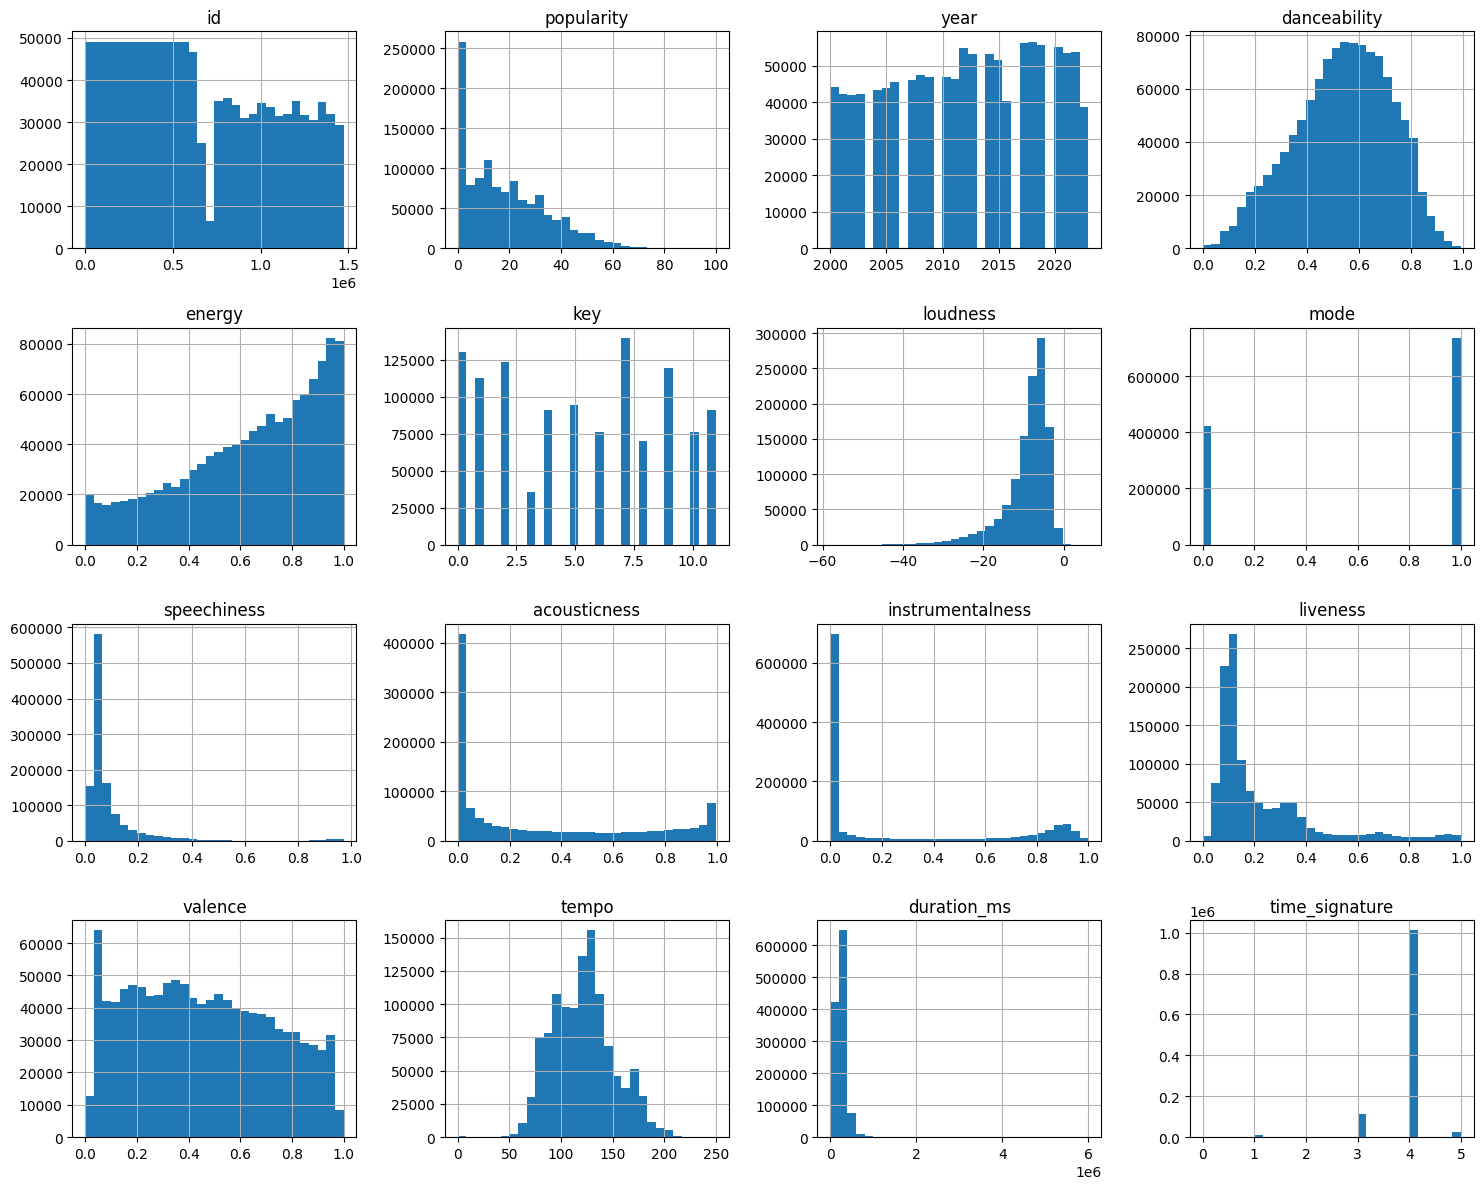

In [23]:
start_time_sk=now()
numeric_cols = [
    col for col in data.select_dtypes(include=[np.number]).columns
    if not col.lower().startswith("unnamed")
]

print("\nSkewness per numeric column:")
print(data[numeric_cols].skew().sort_values(ascending=False))

data[numeric_cols].hist(bins=30, figsize=(15, 12))
plt.tight_layout()
plt.show()
end_time_sk=now()

In [172]:
uuid.uuid4()

UUID('ccfde86b-6ade-4d47-8d4c-cab17f69c54d')

In [24]:
sk_ass_uuid_writer = '3a64927d-3eb9-40a4-b37d-d6dcc68aaa47'

skewness_analysis_comment = """
The skewness analysis indicates that a large number of numerical features in the dataset
deviate from symmetric distributions. Several audio attributes, including duration_ms,
speechiness, and liveness, exhibit strong positive skewness, meaning that most tracks
have relatively low values while a small number of tracks show very high values.
Other features, such as instrumentalness, acousticness, and popularity, display
moderate skewness, reflecting long-tail effects that are typical for streaming platforms.
In contrast, features such as tempo, valence, and danceability are more evenly distributed.
Negative skewness observed for energy and loudness suggests a concentration of tracks
at higher values, which is consistent with contemporary music production practices.
Overall, the results show that assumptions of normality do not hold for many variables,
highlighting the importance of considering distributional properties in later analysis steps.
"""

skewness_report = [
    ':du_skewness_report rdf:type prov:Entity .',
    ':du_skewness_report rdfs:label "2c Skewness Analysis" .',
    f':du_skewness_report rdfs:comment """{skewness_analysis_comment}""" .',
    ':du_skewness_report prov:wasGeneratedBy :skewness_analysis .',
]

skewness_analysis_activity = [
    ':skewness_analysis rdf:type prov:Activity .',
    ':skewness_analysis sc:isPartOf :data_understanding_phase .',
    ':skewness_analysis rdfs:comment \'Data Understanding\' .',
    f':skewness_analysis rdfs:comment """{skewness_analysis_comment}""" .',
    f':skewness_analysis prov:startedAtTime "{start_time_sk}"^^xsd:dateTime .',
    f':skewness_analysis prov:endedAtTime "{end_time_sk}"^^xsd:dateTime .',
    f':skewness_analysis prov:qualifiedAssociation :{sk_ass_uuid_writer} .',
    f':{sk_ass_uuid_writer} rdf:type prov:Association .',
    f':{sk_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # INPUT
    ':skewness_analysis prov:used :data .',
]

engine.insert(skewness_report, prefixes=prefixes)
engine.insert(skewness_analysis_activity, prefixes=prefixes)


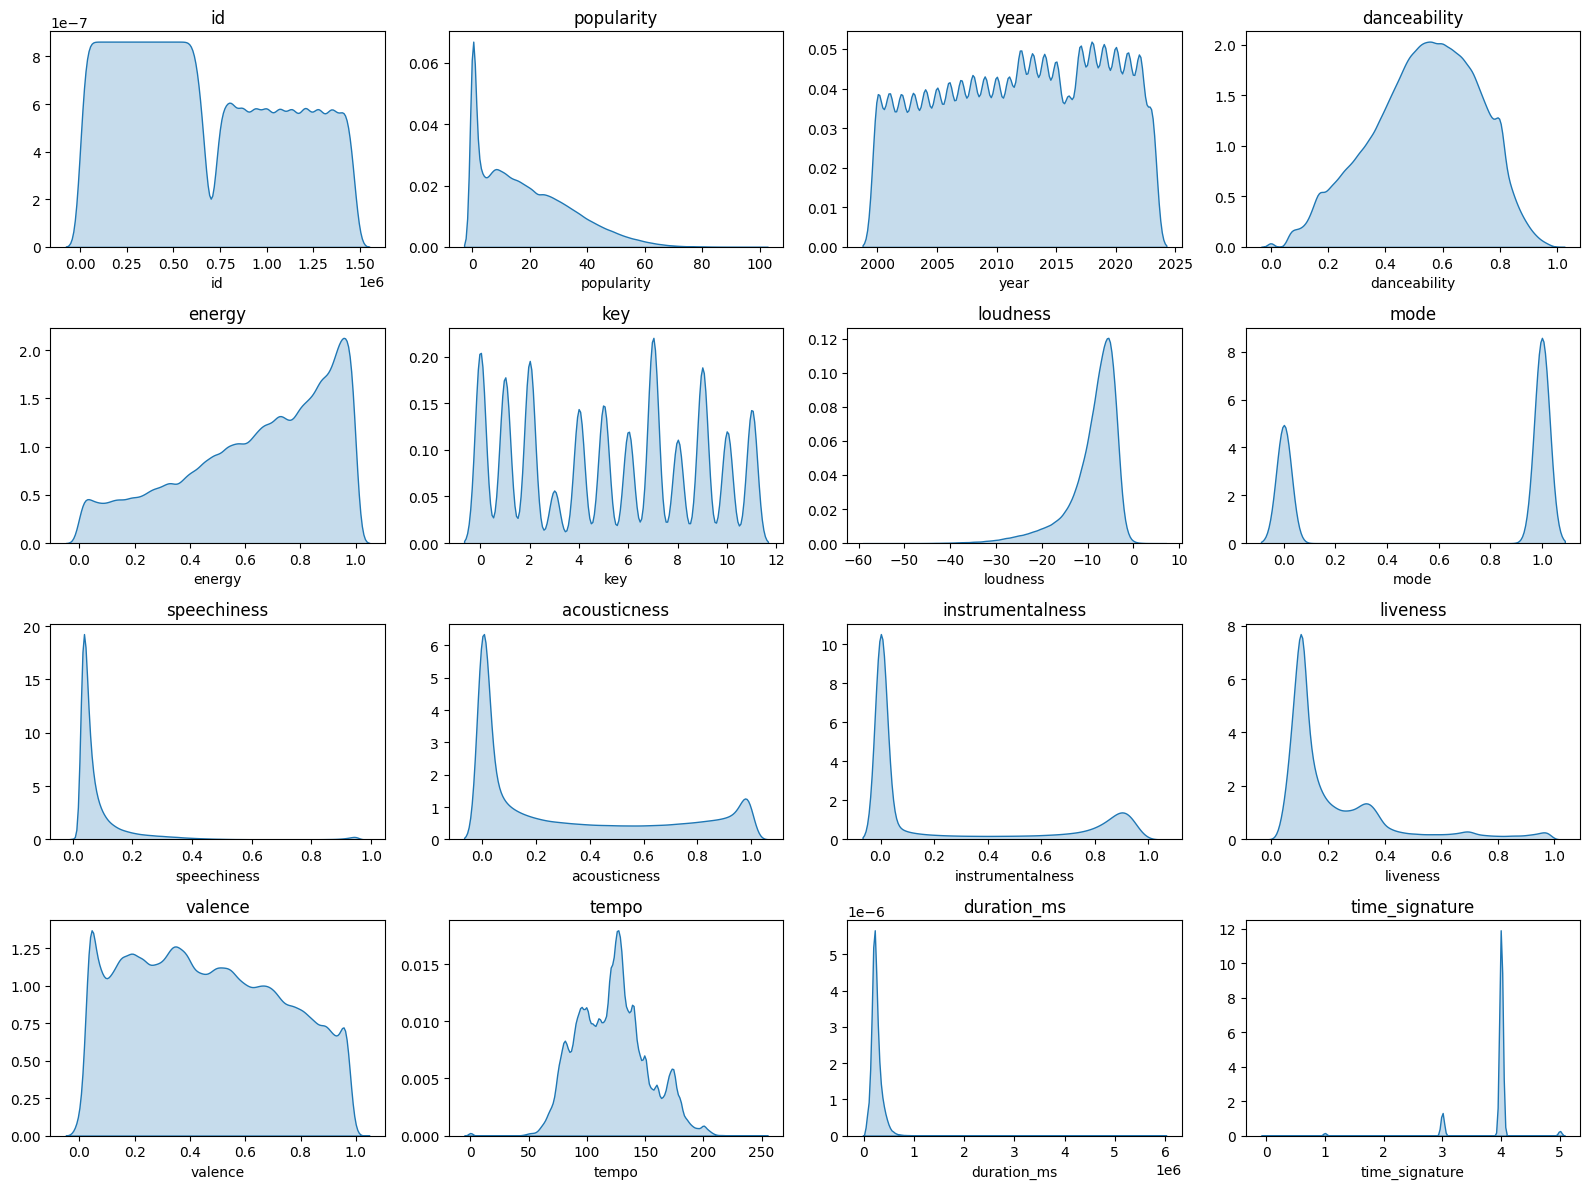

In [25]:
import seaborn as sns
import math

cols = 4
rows = math.ceil(len(numeric_cols) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.kdeplot(data[col], fill=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel("")

for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

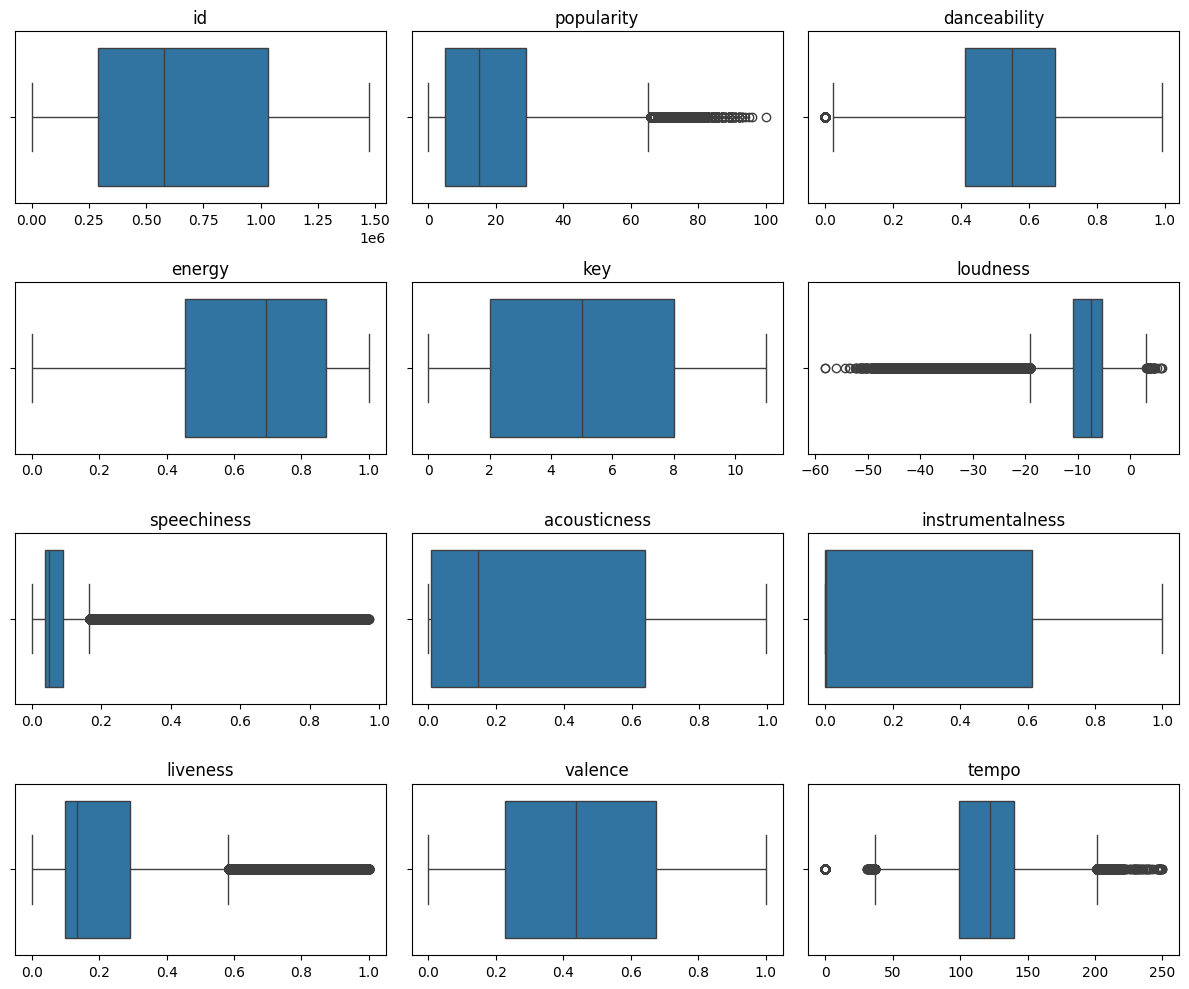

In [26]:
numeric_cols_filtered = [
    col for col in numeric_cols
    if col not in ['duration_ms', 'year', 'mode', 'time_signature']
]

cols = 3
rows = math.ceil(len(numeric_cols_filtered) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 2.5))
axes = axes.flatten()

for i, col in enumerate(numeric_cols_filtered):
    sns.boxplot(x=data[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("")

for j in range(len(numeric_cols_filtered), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


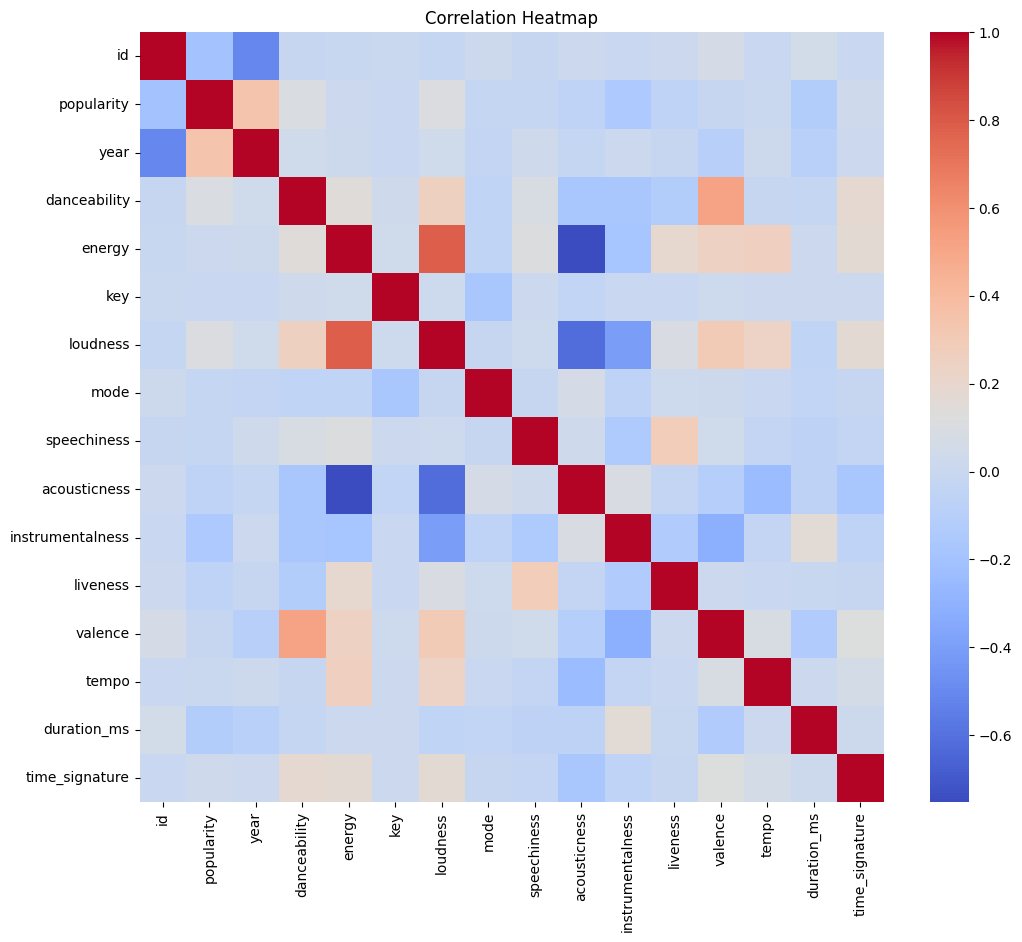

In [27]:
plt.figure(figsize=(12, 10))
sns.heatmap(data[numeric_cols].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [28]:
def check_outliers(
    data: pd.DataFrame,
    columns=(
        'danceability', 'energy', 'speechiness', 'acousticness',
        'instrumentalness', 'liveness', 'valence', 'tempo', 'loudness'
    )
) -> dict:
    
    results = {}

    tmp = data.copy().reset_index(drop=True)

    for col in columns:
        values = tmp[col].astype(float)

        Q1 = values.quantile(0.25)
        Q3 = values.quantile(0.75)
        IQR = Q3 - Q1

        if IQR == 0 or np.isnan(IQR):
            results[col] = []
            continue

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        mask = (values < lower_bound) | (values > upper_bound)
        outlier_indices = values[mask].index

        results[col] = [
            {
                'index': int(idx),
                'value': float(values.loc[idx])
            }
            for idx in outlier_indices
        ]

    all_outlier_indices = {
        entry['index']
        for col in results
        for entry in results[col]
    }

    print(f"Total unique outlier IDs across ALL columns: {len(all_outlier_indices)}")

    return results


outliers_report = check_outliers(data)

for col, outliers in outliers_report.items():
    print(f"{col}: {len(outliers)} outliers")


Total unique outlier IDs across ALL columns: 276464
danceability: 1199 outliers
energy: 0 outliers
speechiness: 137326 outliers
acousticness: 0 outliers
instrumentalness: 0 outliers
liveness: 92203 outliers
valence: 0 outliers
tempo: 5660 outliers
loudness: 75536 outliers


In [29]:

outlier_report_comment = """
Outliers were identified using an IQR-based approach to assess the presence of extreme
values across continuous audio features. The analysis was intended to characterize
distributional properties rather than to remove observations, as many extreme values
represent valid but infrequent musical characteristics. Consequently, outliers were
documented but not excluded at this stage.
"""


outlier_report_entity = [
    ':outlier_report rdf:type prov:Entity .',
    ':outlier_report sc:isPartOf :data_understanding_phase .',
    ':outlier_report rdfs:label "Outlier Analysis" .',
    f':outlier_report rdfs:comment """{outlier_report_comment}""" .',
]

engine.insert(outlier_report_entity, prefixes=prefixes)


## Data Preparation

In [30]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [31]:
def prepare_data(data: pd.DataFrame) -> pd.DataFrame:
    data_clean = data.dropna().copy()

    VALID_BOUNDS = {
        'popularity': (0, 100),
        'year': (2000, 2023),
        'danceability': (0.0, 1.0),
        'energy': (0.0, 1.0),
        'speechiness': (0.0, 1.0),
        'acousticness': (0.0, 1.0),
        'instrumentalness': (0.0, 1.0),
        'liveness': (0.0, 1.0),
        'valence': (0.0, 1.0),
        'key': (-1, 11),
        'mode': (0, 1),
        'time_signature': (3, 7),
        'loudness': (-60.0, 0.0),
        'tempo': (0.0, 300.0),
        'duration_ms': (0, None),
    }

    for col, (low, high) in VALID_BOUNDS.items():
        if col not in data_clean.columns:
            continue
        if low is not None:
            data_clean = data_clean[data_clean[col] >= low]
        if high is not None:
            data_clean = data_clean[data_clean[col] <= high]

    def popularity_bucket(p: int) -> str:
        if 0 <= p <= 20:
            return "Very bad"
        elif 21 <= p <= 40:
            return "Bad"
        elif 41 <= p <= 60:
            return "Average"
        elif 61 <= p <= 80:
            return "Good"
        elif 81 <= p <= 100:
            return "Very good"
        else:
            return "Invalid"

    data_clean["popularity_class"] = data_clean["popularity"].apply(popularity_bucket)

    return data_clean.reset_index(drop=True)

def create_data_preset(clean_data: pd.DataFrame, sample_size: int, random_state: int):
    output_dir = "data"
    output_filename = f"sample_{sample_size}_10_01_2026.csv"

    data_preset = clean_data.sample(n=sample_size, random_state=random_state).reset_index(drop=True)

    output_path = os.path.join(output_dir, output_filename)
    data_preset.to_csv(output_path, index=False)

    print(f"Sample file name: {output_filename}")

    return

In [181]:
uuid.uuid4()

UUID('cdb6e375-1547-46e0-b1be-01e6d8ac278a')

In [32]:
dp_ass_uuid_writer = '67c8989e-83b9-47ce-b517-de12d53af2f4'

start_time_dp = now()
data_clean = prepare_data(data)
create_new_preset = False
if (create_new_preset):
    create_data_preset(data_clean, 100000, 42)
end_time_dp = now()


data_preparation_comment = """
The data preparation step was performed as a single processing activity.
First, all rows containing missing values were removed. The number of such rows
was very small compared to the overall dataset size, and the affected attributes
are required for later analysis, making removal preferable to imputation.

Second, records containing values outside predefined valid bounds were excluded
to ensure semantic correctness and consistency of the data. These bounds were
derived from domain knowledge of Spotify audio features and metadata.

Identified outliers were not removed at this stage. The outlier analysis showed
that extreme values mostly occur in features with naturally skewed or long-tailed
distributions and likely represent valid but infrequent musical characteristics
rather than data errors. Removing them globally could distort the underlying data
distribution and reduce representativeness.

Finally, a new categorical attribute was created by discretizing the popularity
score into five ordered classes (Very bad, Bad, Average, Good, Very good). This
derived attribute supports downstream classification and interpretation while
preserving the original numerical popularity measure.

As a final step of the data preparation process, a reproducible random subset of 
the prepared dataset was created for subsequent modeling experiments. From the fully 
cleaned and enriched data, a uniform random sample of 10,000 records was drawn using a 
fixed random seed to ensure reproducibility. This subset was persisted as a separate 
dataset artifact and is used consistently throughout the modeling phase in order to 
reduce computational effort while maintaining a representative distribution of the 
underlying data.
"""



data_preparation_activity = [
    ':data_preparation rdf:type prov:Activity .',
    ':data_preparation sc:isPartOf :data_preparation_phase .',
    ':data_preparation rdfs:comment "Data Preparation" .',
    f':data_preparation rdfs:comment """{data_preparation_comment}""" .',
    f':data_preparation prov:startedAtTime "{start_time_dp}"^^xsd:dateTime .',
    f':data_preparation prov:endedAtTime "{end_time_dp}"^^xsd:dateTime .',
    f':data_preparation prov:qualifiedAssociation :{dp_ass_uuid_writer} .',
    f':{dp_ass_uuid_writer} rdf:type prov:Association .',
    f':{dp_ass_uuid_writer} prov:agent :{student_a} .',
    f':{dp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':data_preparation prov:used :data .',
    ':data_clean rdf:type prov:Entity .',
    ':data_clean prov:wasGeneratedBy :data_preparation .',
    ':data_clean prov:wasDerivedFrom :data .',

    ':data_preset rdf:type prov:Entity .',
    ':data_preset rdf:type sc:Dataset .',
    ':data_preset prov:wasGeneratedBy :data_preparation .',
    ':data_preset prov:wasDerivedFrom :data_clean .',

    ':data_preset_csv rdf:type prov:Entity .',
    ':data_preset_csv rdf:type sc:File .',
    ':data_preset_csv prov:wasGeneratedBy :data_preparation .',
    ':data_preset_csv prov:atLocation "data/" .',
    ':data_preset_csv prov:wasDerivedFrom :data_preset .',

]

engine.insert(data_preparation_activity, prefixes=prefixes)


In [33]:
prepared_data_triples = [
    ':data_clean rdf:type prov:Entity .',
    ':data_clean rdf:type sc:Dataset .',
    ':data_clean prov:wasDerivedFrom :data .',
]
engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [34]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [35]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_comment = """
The modeling task is formulated as a supervised multi-class classification problem, where the goal
is to predict an ordered popularity class (Very bad, Bad, Average, Good, Very good) based on
Spotify audio features and related metadata.

Several candidate classification algorithms were considered. Multinomial logistic regression was
identified as a simple and interpretable baseline, but its assumption of linear decision boundaries
limits its ability to capture complex relationships between audio characteristics. Support Vector
Machines were also considered due to their strong theoretical properties, however they require
careful feature scaling and can be computationally expensive for larger datasets. Decision Trees
offer non-linear modeling capabilities and interpretability, but are known to be prone to overfitting
when used as single estimators.

The Random Forest classifier was selected as the primary algorithm for the experiments. As an
ensemble method that combines multiple decision trees trained on bootstrap samples with randomized
feature selection, Random Forests effectively reduce variance while preserving the ability to model
non-linear relationships and interactions between features. This is particularly suitable for the
Spotify dataset, where popularity is influenced by complex combinations of audio attributes such as
energy, danceability, tempo, and acousticness.

In addition, Random Forests are robust to noise and outliers, require minimal assumptions about the
underlying data distribution, and perform well with heterogeneous feature types. These properties
make the algorithm well suited for exploratory and predictive modeling in a Business Intelligence
context, where robustness, stability, and reproducibility are prioritized over highly specialized
model tuning.

Based on these considerations, the Random Forest classifier was chosen as the most suitable data
mining algorithm for subsequent modeling and evaluation.
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',
    
    # Evaluation measures (classification)

    # Accuracy
    f':accuracy_measure rdf:type mls:EvaluationMeasure .',
    f':accuracy_measure rdfs:label "Accuracy" .',
    f':accuracy_measure rdfs:comment "Fraction of correctly classified instances across all classes." .',
    f':accuracy_measure prov:wasGeneratedBy :define_algorithm .',

    # Macro-F1
    f':macro_f1_measure rdf:type mls:EvaluationMeasure .',
    f':macro_f1_measure rdfs:label "Macro-averaged F1-score" .',
    f':macro_f1_measure rdfs:comment "F1-score computed per class and averaged equally; robust under class imbalance." .',
    f':macro_f1_measure prov:wasGeneratedBy :define_algorithm .',

    # Weighted-F1
    f':weighted_f1_measure rdf:type mls:EvaluationMeasure .',
    f':weighted_f1_measure rdfs:label "Weighted F1-score" .',
    f':weighted_f1_measure rdfs:comment "F1-score computed per class and averaged weighted by class support; reflects overall performance when classes are imbalanced." .',
    f':weighted_f1_measure prov:wasGeneratedBy :define_algorithm .',

    # Confusion matrix
    f':confusion_matrix_measure rdf:type mls:EvaluationMeasure .',
    f':confusion_matrix_measure rdfs:label "Confusion Matrix" .',
    f':confusion_matrix_measure rdfs:comment "Tabulates predicted vs. true class counts; supports interpretation of systematic misclassifications between popularity classes." .',
    f':confusion_matrix_measure prov:wasGeneratedBy :define_algorithm .',
    
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [36]:
from sklearn.ensemble import RandomForestClassifier

def list_rf_hyperparameters():
    rf = RandomForestClassifier()
    params = rf.get_params()
    num = 1

    print("RandomForestClassifier list of hyperparameters:\n")
    for key in sorted(params.keys()):
        print(f"{num}. {key}: {params[key]}")
        num += 1

list_rf_hyperparameters()

RandomForestClassifier list of hyperparameters:

1. bootstrap: True
2. ccp_alpha: 0.0
3. class_weight: None
4. criterion: gini
5. max_depth: None
6. max_features: sqrt
7. max_leaf_nodes: None
8. max_samples: None
9. min_impurity_decrease: 0.0
10. min_samples_leaf: 1
11. min_samples_split: 2
12. min_weight_fraction_leaf: 0.0
13. monotonic_cst: None
14. n_estimators: 100
15. n_jobs: None
16. oob_score: False
17. random_state: None
18. verbose: 0
19. warm_start: False


In [37]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_comment = """
The RandomForestClassifier exposes several hyperparameters that influence model complexity,
generalization behavior, robustness to noise, and computational cost. Prior to selecting a
parameter for tuning, multiple hyperparameters were examined.

The parameter n_estimators controls the number of trees in the ensemble. Increasing this value
generally improves prediction stability but also increases training time, while performance
improvements typically plateau beyond a certain number of trees. The max_features parameter
determines how many features are considered at each split and influences the diversity of trees
within the ensemble; although relevant in high-dimensional settings, it is often secondary once
sufficient feature interactions are captured.

The parameters min_samples_split and min_samples_leaf act as regularization mechanisms by limiting
tree growth. Higher values enforce smoother decision boundaries and can reduce overfitting,
particularly in the presence of noise or outliers. The class_weight parameter was also considered
to address potential class imbalance by re-weighting misclassification penalties, which can improve
macro-averaged evaluation metrics. The bootstrap parameter controls whether bootstrap sampling is
applied and is typically left at its default value, as it rarely serves as the primary tuning
dimension.

Among these options, max_depth was selected as the most relevant hyperparameter for tuning.
The max_depth parameter directly controls the complexity of individual decision trees: shallow
trees may underfit complex, non-linear relationships between audio features, while very deep trees
increase the risk of overfitting and computational cost. Tuning max_depth therefore provides a
transparent and effective way to balance predictive performance, generalization, and training
efficiency.

The max_depth parameter is evaluated over a small set of discrete values representing increasing 
model complexity (e.g., 5, 10, 15, 20, and an unconstrained setting). This interval-based approach 
allows transparent analysis of the bias–variance tradeoff while keeping computational effort manageable.
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',

    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Random Forest hyperparameters (identified)

    f':hp_n_estimators rdf:type mls:HyperParameter .',
    f':hp_n_estimators rdfs:label "n_estimators" .',
    f':hp_n_estimators rdfs:comment "Number of trees in the forest; improves stability but increases computational cost." .',
    f':random_forest_classifier_implementation mls:hasHyperParameter :hp_n_estimators .',
    f':hp_n_estimators prov:wasGeneratedBy :identify_hyperparameters .',

    f':hp_max_depth rdf:type mls:HyperParameter .',
    f':hp_max_depth rdfs:label "max_depth" .',
    f':hp_max_depth rdfs:comment "Maximum depth of individual trees; primary tuning parameter controlling model complexity and generalization." .',
    f':random_forest_classifier_implementation mls:hasHyperParameter :hp_max_depth .',
    f':hp_max_depth prov:wasGeneratedBy :identify_hyperparameters .',

    f':hp_min_samples_leaf rdf:type mls:HyperParameter .',
    f':hp_min_samples_leaf rdfs:label "min_samples_leaf" .',
    f':hp_min_samples_leaf rdfs:comment "Minimum samples required at a leaf node; acts as regularization to reduce overfitting." .',
    f':random_forest_classifier_implementation mls:hasHyperParameter :hp_min_samples_leaf .',
    f':hp_min_samples_leaf prov:wasGeneratedBy :identify_hyperparameters .',

    f':hp_min_samples_split rdf:type mls:HyperParameter .',
    f':hp_min_samples_split rdfs:label "min_samples_split" .',
    f':hp_min_samples_split rdfs:comment "Minimum samples required to split an internal node; limits tree growth and overfitting." .',
    f':random_forest_classifier_implementation mls:hasHyperParameter :hp_min_samples_split .',
    f':hp_min_samples_split prov:wasGeneratedBy :identify_hyperparameters .',

    f':hp_max_features rdf:type mls:HyperParameter .',
    f':hp_max_features rdfs:label "max_features" .',
    f':hp_max_features rdfs:comment "Number of features considered at each split; affects tree diversity and ensemble robustness." .',
    f':random_forest_classifier_implementation mls:hasHyperParameter :hp_max_features .',
    f':hp_max_features prov:wasGeneratedBy :identify_hyperparameters .',

    f':hp_class_weight rdf:type mls:HyperParameter .',
    f':hp_class_weight rdfs:label "class_weight" .',
    f':hp_class_weight rdfs:comment "Weights associated with classes; useful for handling class imbalance and improving macro-F1." .',
    f':random_forest_classifier_implementation mls:hasHyperParameter :hp_class_weight .',
    f':hp_class_weight prov:wasGeneratedBy :identify_hyperparameters .',

    f':hp_bootstrap rdf:type mls:HyperParameter .',
    f':hp_bootstrap rdfs:label "bootstrap" .',
    f':hp_bootstrap rdfs:comment "Controls whether bootstrap samples are used when building trees; typically left at default." .',
    f':random_forest_classifier_implementation mls:hasHyperParameter :hp_bootstrap .',
    f':hp_bootstrap prov:wasGeneratedBy :identify_hyperparameters .',
    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(df: pd.DataFrame, target_col: str, train_size: float, val_size: float, test_size: float, random_state: int):
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataframe.")
    if abs((train_size + val_size + test_size) - 1.0) > 1e-9:
        raise ValueError("train_size + val_size + test_size must sum to 1.0")

    # 1) train vs temporary (val+test)
    train_set, temp_set = train_test_split(
        df,
        test_size=(val_size + test_size),
        random_state=random_state,
        stratify=df[target_col]
    )

    # 2) val vs test from temp
    test_frac_of_temp = test_size / (val_size + test_size)

    validation_set, test_set = train_test_split(
        temp_set,
        test_size=test_frac_of_temp,
        random_state=random_state,
        stratify=temp_set[target_col]
    )
    return train_set, validation_set, test_set

spotify_data_path = os.path.join("data")
input_file = os.path.join(spotify_data_path, 'sample_100000_10_01_2026.csv')
sample_data = pd.read_csv(input_file,  sep=',', header = 0)

start_time_split = now()
train_set, validation_set, test_set = split_data(sample_data, "popularity_class", 0.60, 0.20, 0.20, 42)
end_time_split = now()

n_train, n_validation, n_test = len(train_set), len(validation_set), len(test_set)
print("Split sizes:", n_train, n_validation, n_test)

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_comment = f"""
The prepared dataset was split into three disjoint subsets for supervised learning: a training set,
a validation set, and a test set. Because the target variable consists of five popularity classes
(Very bad, Bad, Average, Good, Very good), stratified sampling was applied to preserve the class
distribution across all subsets.

The split was defined as 60% training, 20% validation, and 20% test. A fixed random seed
(random_state=42) was used to ensure reproducibility. No temporal or sequential dependencies
between instances were assumed for this task, therefore a random stratified split was appropriate.

Resulting subset sizes are: training={n_train}, validation={n_validation}, test={n_test}.
"""

## Use your prepared dataset
input_dataset = ":sample_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:startedAtTime "{start_time_split}"^^xsd:dateTime .',
    f':define_data_split prov:endedAtTime "{end_time_split}"^^xsd:dateTime .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',

    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains {n_train} samples" .',

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains {n_validation} samples" .',

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains {n_test} samples" .',

    
]
engine.insert(define_split_activity, prefixes=prefixes)

Split sizes: 60000 20000 20000


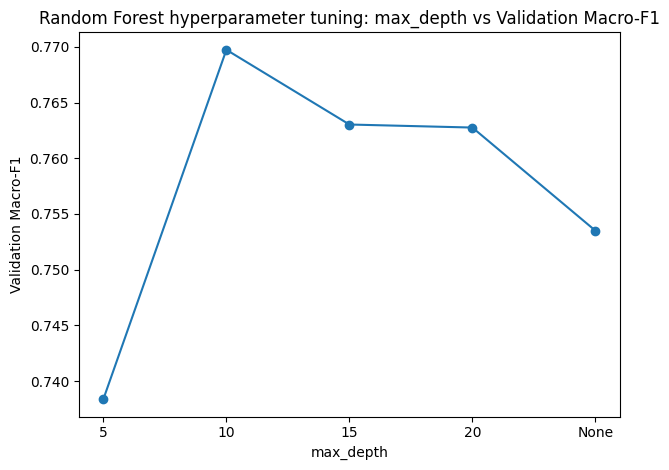

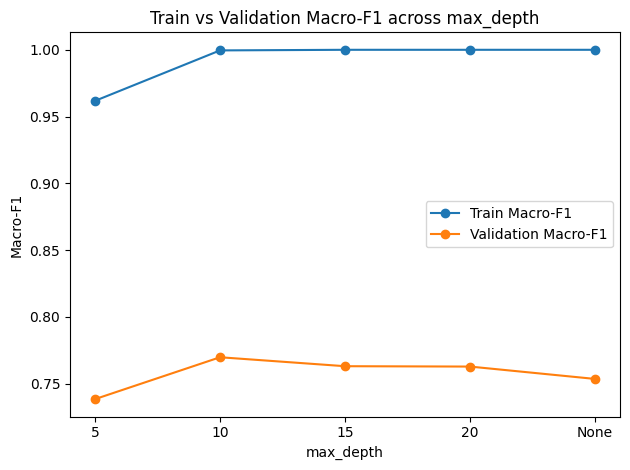

Best max_depth: 10


,run,max_depth,train_accuracy,val_accuracy,train_macro_f1,val_macro_f1,train_weighted_f1,val_weighted_f1
0,run_1,5,0.974000,0.9650,0.961758,0.738377,0.974339,0.965082
1,run_2,10,0.999667,0.9940,0.999547,0.769732,0.999667,0.993708
2,run_3,15,1.000000,0.9950,1.000000,0.763025,1.000000,0.994610
3,run_4,20,1.000000,0.9948,1.000000,0.762753,1.000000,0.994413
4,run_5,None,1.000000,0.9944,1.000000,0.753497,1.000000,0.993884


Best parameters:
- n_estimators : 1000
- random_state : 42
- n_jobs : -1
- max_features : sqrt
- class_weight : balanced
- min_samples_leaf : 2
- min_samples_split : 4
- bootstrap : True
- criterion : gini
- max_depth: 10


In [64]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

def train_and_finetune_model(
    training_set: pd.DataFrame,
    validation_set: pd.DataFrame,
    target_col: str = "popularity_class",
    max_depth_grid=(5, 10, 15, 20, None),
    base_params: dict | None = None,
    output_fig_dir: str = "figures"
):
    if target_col not in training_set.columns:
        raise ValueError(f"Target column '{target_col}' not found in training_set.")
    if target_col not in validation_set.columns:
        raise ValueError(f"Target column '{target_col}' not found in validation_set.")

    os.makedirs(output_fig_dir, exist_ok=True)

    # Split into X/y
    X_train = training_set.drop(columns=[target_col], errors="ignore").copy()
    y_train = training_set[target_col].copy()

    X_val = validation_set.drop(columns=[target_col], errors="ignore").copy()
    y_val = validation_set[target_col].copy()

    # Drop high-cardinality / identifier columns (not used as features)
    DROP_COLS = ["id", "artist_name", "track_name", "track_id"]
    X_train = X_train.drop(columns=[c for c in DROP_COLS if c in X_train.columns], errors="ignore")
    X_val = X_val.drop(columns=[c for c in DROP_COLS if c in X_val.columns], errors="ignore")

    # Encoding (genre + any other categorical columns)
    cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = [c for c in X_train.columns if c not in cat_cols]

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ],
        remainder="drop"
    )

    rows = []
    prov_triples = []

    # Selection criterion: validation Macro-F1
    best_model = None 
    best_depth = None
    best_val_macro_f1 = -1.0

    # Shared hyperparameters
    base_params = base_params

    fig_filename_1 = f"rf_tuning_max_depth_{datetime.date.today().strftime('%Y_%m_%d')}.png"
    fig_path_1 = os.path.join(output_fig_dir, fig_filename_1)

    fig_filename_2 = f"rf_train_vs_validation_{datetime.date.today().strftime('%Y_%m_%d')}.png"
    fig_path_2 = os.path.join(output_fig_dir, fig_filename_2)

    for i, depth in enumerate(max_depth_grid, start=1):
        run_id = f"run_{i}"
        model_id = f"rf_model_{i}"
        hp_setting_id = f"hp_setting_max_depth_{i}"

        # Train model (inside a pipeline with encoding)
        clf = RandomForestClassifier(max_depth=depth, **base_params)
        pipe = Pipeline(steps=[
            ("preprocess", preprocessor),
            ("model", clf)
        ])

        pipe.fit(X_train, y_train)

        # Predictions
        pred_train = pipe.predict(X_train)
        pred_val = pipe.predict(X_val)

        # Metrics
        train_acc = accuracy_score(y_train, pred_train)
        val_acc = accuracy_score(y_val, pred_val)

        train_macro_f1 = f1_score(y_train, pred_train, average="macro")
        val_macro_f1 = f1_score(y_val, pred_val, average="macro")

        train_weighted_f1 = f1_score(y_train, pred_train, average="weighted")
        val_weighted_f1 = f1_score(y_val, pred_val, average="weighted")

        rows.append({
            "run": run_id,
            "max_depth": depth if depth is not None else "None",
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "train_macro_f1": train_macro_f1,
            "val_macro_f1": val_macro_f1,
            "train_weighted_f1": train_weighted_f1,
            "val_weighted_f1": val_weighted_f1
        })

        # Select best by validation Macro-F1
        if val_macro_f1 > best_val_macro_f1:
            best_val_macro_f1 = val_macro_f1
            best_model = pipe      # store pipeline (preprocess + RF)
            best_depth = depth

        # ----------------------------
        # Provenance triples for this run
        # ----------------------------
        depth_literal = '"None"' if depth is None else f'"{float(depth)}"^^xsd:double'
        prov_triples.extend([
            f':{hp_setting_id} rdf:type mls:HyperParameterSetting .',
            f':{hp_setting_id} mls:specifiedBy :hp_max_depth .',
            f':{hp_setting_id} mls:hasValue {depth_literal} .',
            f':{hp_setting_id} prov:wasGeneratedBy :train_and_finetune_model .',

            f':{run_id} rdf:type mls:Run .',
            f':{run_id} sc:isPartOf :train_and_finetune_model .',
            f':{run_id} mls:realizes :random_forest_algorithm .',
            f':{run_id} rdfs:label "Random Forest run {i} (max_depth={depth})" .',
            f':{run_id} mls:executes :random_forest_classifier_implementation .',
            f':{run_id} mls:hasInput :training_set .',
            f':{run_id} mls:hasInput :validation_set .',
            f':{run_id} mls:hasInput :{hp_setting_id} .',
            f':{run_id} mls:hasOutput :{model_id} .',

            f':{model_id} rdf:type mls:Model .',
            f':{model_id} rdfs:label "RandomForestClassifier pipeline model from run {i}" .',
            f':{model_id} prov:wasGeneratedBy :{run_id} .',
            f':{model_id} mlso:trainedOn :training_set .',
            f':{model_id} mlso:hasAlgorithmType :random_forest_algorithm .',
        ])

        eval_train_acc = f"eval_train_acc_{i}"
        eval_val_acc = f"eval_val_acc_{i}"
        eval_train_macro = f"eval_train_macro_f1_{i}"
        eval_val_macro = f"eval_val_macro_f1_{i}"

        prov_triples.extend([
            f':{eval_train_acc} rdf:type mls:ModelEvaluation .',
            f':{eval_train_acc} prov:wasGeneratedBy :{run_id} .',
            f':{eval_train_acc} mls:hasValue "{train_acc}"^^xsd:double .',
            f':{eval_train_acc} mls:specifiedBy :accuracy_measure .',
            f':{eval_train_acc} prov:used :training_set .',

            f':{eval_val_acc} rdf:type mls:ModelEvaluation .',
            f':{eval_val_acc} prov:wasGeneratedBy :{run_id} .',
            f':{eval_val_acc} mls:hasValue "{val_acc}"^^xsd:double .',
            f':{eval_val_acc} mls:specifiedBy :accuracy_measure .',
            f':{eval_val_acc} prov:used :validation_set .',

            f':{eval_train_macro} rdf:type mls:ModelEvaluation .',
            f':{eval_train_macro} prov:wasGeneratedBy :{run_id} .',
            f':{eval_train_macro} mls:hasValue "{train_macro_f1}"^^xsd:double .',
            f':{eval_train_macro} mls:specifiedBy :macro_f1_measure .',
            f':{eval_train_macro} prov:used :training_set .',

            f':{eval_val_macro} rdf:type mls:ModelEvaluation .',
            f':{eval_val_macro} prov:wasGeneratedBy :{run_id} .',
            f':{eval_val_macro} mls:hasValue "{val_macro_f1}"^^xsd:double .',
            f':{eval_val_macro} mls:specifiedBy :macro_f1_measure .',
            f':{eval_val_macro} prov:used :validation_set .',
        ])

    results_df = pd.DataFrame(rows)

    # Plot tuning curve
    x_labels = results_df["max_depth"].astype(str).tolist()
    x = np.arange(len(x_labels))

    plt.figure()
    plt.plot(x, results_df["val_macro_f1"].values, marker="o")
    plt.xticks(x, x_labels)
    plt.xlabel("max_depth")
    plt.ylabel("Validation Macro-F1")
    plt.title("Random Forest hyperparameter tuning: max_depth vs Validation Macro-F1")
    plt.tight_layout()
    plt.savefig(fig_path_1, dpi=150)
    plt.show()

    prov_triples.extend([
        f':rf_tuning_plot rdf:type prov:Entity .',
        f':rf_tuning_plot rdfs:label "Tuning curve: max_depth vs validation Macro-F1" .',
        f':rf_tuning_plot prov:wasGeneratedBy :train_and_finetune_model .',
        f':rf_tuning_plot prov:atLocation "{fig_path}" .',
    ])

    plt.figure()
    plt.plot(x, results_df["train_macro_f1"].values, marker="o", label="Train Macro-F1")
    plt.plot(x, results_df["val_macro_f1"].values, marker="o", label="Validation Macro-F1")
    plt.xticks(x, x_labels)
    plt.xlabel("max_depth")
    plt.ylabel("Macro-F1")
    plt.title("Train vs Validation Macro-F1 across max_depth")
    plt.legend()
    plt.tight_layout()
    plt.savefig(fig_path_2, dpi=150)
    plt.show()

    prov_triples.extend([
    f':rf_tuning_train_vs_val_plot rdf:type prov:Entity .',
    f':rf_tuning_train_vs_val_plot rdfs:label "Train vs Validation Macro-F1 across max_depth" .',
    f':rf_tuning_train_vs_val_plot prov:wasGeneratedBy :train_and_finetune_model .',
    f':rf_tuning_train_vs_val_plot prov:atLocation "{fig_path_2}" .',
    ])

    return best_model, best_depth, results_df, fig_path, prov_triples


start_time_tafm = now()
base_params = {
    "n_estimators": 1000,
    "random_state": 42,
    "n_jobs": -1,
    "max_features": "sqrt",
    "class_weight": "balanced",
    "min_samples_leaf": 2,
    "min_samples_split": 4,
    "bootstrap": True,
    "criterion": "gini"
}

train_25, _ = train_test_split(train_set, test_size=0.75, random_state=42, stratify=train_set["popularity_class"])
validation_25, _ = train_test_split(validation_set, test_size=0.75, random_state=42, stratify=validation_set["popularity_class"])

best_model, best_depth, tuning_results, fig_path, run_triples = train_and_finetune_model(
    training_set=train_25,
    validation_set=validation_25,
    target_col="popularity_class",
    base_params=base_params
)
end_time_tafm = now()

print("Best max_depth:", best_depth)
display(tuning_results)
print("Best parameters:")
for p in base_params:
    print("-",p,":", base_params[p])
print("- max_depth:",best_depth)


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_comment = f"""
Random Forest training and hyperparameter tuning were performed using a fixed train/validation split.
Multiple model runs were executed by varying the hyperparameter max_depth over a predefined grid
(max_depth ∈ 5, 10, 15, 20, None). All other model parameters were held constant across runs to ensure
comparability and reproducibility.

To enable experimentation with computationally more demanding configurations, the hyperparameter
tuning experiments were conducted on stratified subsets containing 25% of the original training set
and 25% of the original validation set. This subsampling strategy reduced computational overhead while
preserving the class distribution and relative data characteristics. The reduced dataset size allowed
the use of a larger ensemble size (n_estimators = 1000) to improve model stability without prohibitive
runtime costs.

The following Random Forest parameters were fixed for all training runs: n_estimators = 1000,
random_state = 42, n_jobs = -1, max_features = "sqrt", class_weight = "balanced",
min_samples_leaf = 2, min_samples_split = 4, bootstrap = True, and criterion = "gini".
Only the max_depth parameter was varied during tuning.

For each run, a preprocessing-and-model pipeline was trained on the (subsampled) training set.
Categorical attributes (e.g., genre) were one-hot encoded (handle_unknown="ignore"), while numeric
attributes were passed through unchanged. High-cardinality identifiers (artist_name, track_name,
track_id) were excluded from the feature space. Although artist popularity is known to influence song
success, artist identifiers were excluded to avoid identity-based memorization and to focus the model
on generalizable musical characteristics. Track name and track identifiers were removed as they do not
represent intrinsic musical properties relevant for popularity prediction.

Model performance was evaluated on both the training and validation sets using Accuracy and
Macro-averaged F1-score. Macro-F1 on the validation set served as the primary model selection criterion
due to its robustness under potential class imbalance across the five popularity classes. Two figures
were generated to support the analysis: (1) a tuning curve showing validation Macro-F1 across max_depth
values, and (2) a plot comparing training vs. validation Macro-F1 to diagnose overfitting. The final
hyperparameter setting was selected as the one achieving the highest validation Macro-F1 (selected
max_depth = {best_depth}).
"""

train_model_activity = [
    # Activity
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',

    # Association
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':train_and_finetune_model prov:used :training_set .',
    f':train_and_finetune_model prov:used :validation_set .',

    # Explicitly document selection result
    f':selected_model rdf:type prov:Entity .',
    f':selected_model rdfs:label "Selected model based on validation Macro-F1" .',
    f':selected_model prov:wasGeneratedBy :train_and_finetune_model .',
    f':selected_model rdfs:comment "Best max_depth chosen by highest validation Macro-F1 was: {best_depth}" .',
]

# Append all run/model/evaluation/plot triples produced by your function
train_model_activity.extend(run_triples)

engine.insert(train_model_activity, prefixes=prefixes)


In [ ]:
def retrain_model_full_data(
    training_set: pd.DataFrame,
    validation_set: pd.DataFrame,
    target_col: str = "popularity_class",
    best_depth=None,
    base_params: dict | None = None,
    drop_cols=None
):
    if drop_cols is None:
        drop_cols = ["id", "artist_name", "track_name", "track_id"]

    if base_params is None:
        base_params = {
            "n_estimators": 1000,
            "random_state": 42,
            "n_jobs": -1,
            "max_features": "sqrt",
            "class_weight": "balanced",
            "min_samples_leaf": 2,
            "min_samples_split": 4,
            "bootstrap": True,
            "criterion": "gini"
        }

    # Combine training and validation sets
    full_train = pd.concat([training_set, validation_set], axis=0).reset_index(drop=True)

    # Split into X/y
    X_full = full_train.drop(columns=[target_col], errors="ignore").copy()
    y_full = full_train[target_col].copy()

    # Drop identifier / high-cardinality columns
    X_full = X_full.drop(columns=[c for c in drop_cols if c in X_full.columns], errors="ignore")

    # Identify categorical and numeric columns
    cat_cols = X_full.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = [c for c in X_full.columns if c not in cat_cols]

    # Preprocessing (encode genre, pass numeric)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ],
        remainder="drop"
    )

    # Final model with selected hyperparameters
    clf = RandomForestClassifier(max_depth=best_depth, **base_params)

    final_model = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", clf)
    ])

    final_model.fit(X_full, y_full)

    return final_model


start_time_retrain = now()
final_model = retrain_model_full_data(
    training_set=train_set,
    validation_set=validation_set,
    target_col="popularity_class",
    best_depth=best_depth,
    base_params=base_params
)
end_time_retrain = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993" # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
retrain_comment = f"""
The final model was retrained after hyperparameter selection using the full available training data,
i.e., the union of the training and validation sets. Retraining was performed using the same
preprocessing pipeline and identical hyperparameters as the best configuration identified during
tuning (max_depth = {best_depth}). Categorical features (e.g., genre) were one-hot encoded with
handle_unknown="ignore", numeric features were passed through unchanged, and identifier/high-cardinality
attributes (artist_name, track_name, track_id) were excluded from the feature space.

Fixed Random Forest parameters during retraining were: n_estimators = {base_params["n_estimators"]},
random_state = {base_params["random_state"]}, n_jobs = {base_params["n_jobs"]}, max_features = "{base_params["max_features"]}",
class_weight = "{base_params["class_weight"]}", min_samples_leaf = {base_params["min_samples_leaf"]},
min_samples_split = {base_params["min_samples_split"]}, bootstrap = {base_params["bootstrap"]}, and criterion = "{base_params["criterion"]}".
"""


retrain_documentation = [
    # Activity
    f'{final_training_activity} rdf:type prov:Activity .',
    f'{final_training_activity} sc:isPartOf :modeling_phase .',
    f'{final_training_activity} rdfs:comment "Final model retraining on train+validation data" .',
    f'{final_training_activity} rdfs:comment """{retrain_comment}""" .',
    f'{final_training_activity} prov:startedAtTime "{start_time_retrain}"^^xsd:dateTime .',
    f'{final_training_activity} prov:endedAtTime "{end_time_retrain}"^^xsd:dateTime .',
    f'{final_training_activity} prov:qualifiedAssociation :{retrain_ass_uuid_writer} .',

    # Association
    f':{retrain_ass_uuid_writer} rdf:type prov:Association .',
    f':{retrain_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{retrain_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Inputs
    f'{final_training_activity} prov:used :training_set .',
    f'{final_training_activity} prov:used :validation_set .',

    # Hyperparameter setting (selected)
    f':final_hp_max_depth rdf:type mls:HyperParameterSetting .',
    f':final_hp_max_depth mls:specifiedBy :hp_max_depth .',
    f':final_hp_max_depth mls:hasValue {"\"None\"" if best_depth is None else f"\"{float(best_depth)}\"^^xsd:double"} .',
    f':final_hp_max_depth prov:wasGeneratedBy {final_training_activity} .',

    # Final model entity
    f'{final_model} rdf:type mls:Model .',
    f'{final_model} rdfs:label "Final RandomForestClassifier pipeline model (trained on train+validation)" .',
    f'{final_model} prov:wasGeneratedBy {final_training_activity} .',
    f'{final_model} mlso:trainedOn :training_set .',
    f'{final_model} mlso:trainedOn :validation_set .',
    f'{final_model} mlso:hasAlgorithmType :random_forest_algorithm .',
]

engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [249]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [75]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [76]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [77]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

In [79]:
engine.query(f"""
{prefix_header}
SELECT (COUNT(?field) AS ?n) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
}}
""")


,n
0,"""0""^^<http://www.w3.org/2001/XMLSchema#integer>"


In [146]:
debug_query = f"""
{prefix_header}

SELECT ?entity (COUNT(?comment) AS ?n) WHERE {{
  VALUES ?entity {{
    :data_volume_report
    :du_skewness_analysis
  }}
  ?entity rdfs:comment ?comment .
}}
GROUP BY ?entity
"""

engine.query(debug_query)


,entity,n
0,<https://starvers.ec.tuwien.ac.at/BI2025/02/data_volume_report>,"""3""^^<http://www.w3.org/2001/XMLSchema#integer>"
1,<https://starvers.ec.tuwien.ac.at/BI2025/02/du_skewness_analysis>,"""2""^^<http://www.w3.org/2001/XMLSchema#integer>"


# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [184]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [185]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [186]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT
  ?ds_comment
  ?bo_comment
  ?bsc_comment
  ?dmg_comment
  ?dmsc_comment
  ?air_comment
WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
  OPTIONAL {{ :bu_business_success_criteria rdfs:comment ?bsc_comment . }}
  OPTIONAL {{ :bu_data_mining_goals rdfs:comment ?dmg_comment . }}
  OPTIONAL {{ :bu_data_mining_success_criteria rdfs:comment ?dmsc_comment . }}
  OPTIONAL {{ :bu_ai_risk_aspects rdfs:comment ?air_comment . }}
}}
LIMIT 1
"""

res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {}  # type:ignore

bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))
bu_business_success = latex_escape(clean_rdf(row_bu.get("bsc_comment", "")))
bu_data_mining_goals = latex_escape(clean_rdf(row_bu.get("dmg_comment", "")))
bu_data_mining_success = latex_escape(clean_rdf(row_bu.get("dmsc_comment", "")))
bu_ai_risks = latex_escape(clean_rdf(row_bu.get("air_comment", "")))



### Data Understanding – Analysis Results (Reports)

du_analysis_query = f"""
{prefix_header}

SELECT ?label (SAMPLE(?commentRaw) AS ?comment) WHERE {{
  VALUES ?entity {{
    :data_volume_report
    :du_skewness_analysis
    :outlier_report
  }}
  ?entity rdfs:label ?label .
  ?entity rdfs:comment ?commentRaw .
}}
GROUP BY ?label
"""

res_du_analysis = engine.query(du_analysis_query)

du_analysis_sections = ""

if not res_du_analysis.empty:  # type: ignore
    for _, row in res_du_analysis.iterrows():  # type: ignore
        label = latex_escape(clean_rdf(row["label"]))
        comment = latex_escape(clean_rdf(row["comment"]))

        du_analysis_sections += rf"""
\subsubsection{{{label}}}
{comment}
"""

### Data Preparation – Report

dp_query = f"""
{prefix_header}

SELECT (SAMPLE(?commentRaw) AS ?comment) WHERE {{
  :data_preparation rdfs:comment ?commentRaw .
}}
"""

res_dp = engine.query(dp_query)

dp_section = ""

if not res_dp.empty:  # type: ignore
    dp_comment = latex_escape(clean_rdf(res_dp.iloc[0]["comment"]))  # type: ignore
    dp_section = dp_comment


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

Data extraction done.


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [187]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

\subsection{{Business Success Criteria}}
{bu_business_success}

\subsection{{Data Mining Goals}}
{bu_data_mining_goals}

\subsection{{Data Mining Success Criteria}}
{bu_data_mining_success}

\subsection{{AI Risk Aspects}}
{bu_ai_risks}



%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}


\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

{du_analysis_sections}

{du_outlier_sections}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.
{dp_section}

\end{{document}}
"""

In [188]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data/report/experiment_report.tex
